####         INF2178 Midterm Code - Effect of Multiple Factors on the Level of Cooperation at the Time of Arrest
####    This code is contributed by Laien Zhou (1005490434) and Yuelin Liu (1003175164)

### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import statsmodels
from scipy import stats
from scipy.stats import levene
import scipy.stats
import math
import random
import statistics
import scipy.stats as sp
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
import statsmodels.stats.api as sms

!pip install scikit_posthocs
!pip install researchpy
import researchpy as rp

### Exploratory Data Analysis (EDA):
#### includes descriptive statistics, t-tests, state your hypotheses for your t-tests

In [2]:
# read the data
df = pd.read_csv("https://raw.githubusercontent.com/LaienZhou/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

In [3]:
# valid data

# sex:
valid_sex = (df["Sex"] == "M") | (df["Sex"] == "F")
# perceived_race:
valid_race = (df["Perceived_Race"] == "White") | (df["Perceived_Race"] == "Black") | (df["Perceived_Race"] == "East/Southeast Asian") | (df["Perceived_Race"] == "South Asian") | (df["Perceived_Race"] == "Middle-Eastern") | (df["Perceived_Race"] == "Latino") | (df["Perceived_Race"] == "Indigenous")

valid_data = valid_sex & valid_race
df = df[valid_data]
df

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5
5,2021,Apr-June,1019145,6060688.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,42,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65270,2021,Oct-Dec,1046034,6029720.0,311475,White,F,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65271
65271,2021,Oct-Dec,1055609,6044336.0,316123,Indigenous,F,Aged 25 to 34 years,Not a youth,XX,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,65272
65272,2021,Oct-Dec,1032758,6031692.0,307736,South Asian,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65273
65273,2021,Oct-Dec,1021067,6064396.0,324057,White,F,Aged 45 to 54 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65274


In [4]:
# data rename

# ArrestLocDiv -> intoronto :
df.rename(columns={'ArrestLocDiv':'intoronto'}, inplace=True)
df.loc[df["intoronto"] != "XX","intoronto"] = "1"
df.loc[df["intoronto"] == "XX","intoronto"] = "0"

In [5]:
# data reallocation

# Age_group__at_arrest_:
df.loc[(df["Age_group__at_arrest_"] == "Aged 17 years and under") | (df["Age_group__at_arrest_"] == "Aged 17 years and younger") ,["Age_group__at_arrest_"]] = "-18"
df.loc[(df["Age_group__at_arrest_"] == "Aged 65 years and older") | (df["Age_group__at_arrest_"] == "Aged 65 and older") ,["Age_group__at_arrest_"]] = "65+"
df.loc[(df["Age_group__at_arrest_"] == "Aged 18 to 24 years") ,["Age_group__at_arrest_"]] = "18-24"
df.loc[(df["Age_group__at_arrest_"] == "Aged 25 to 34 years") ,["Age_group__at_arrest_"]] = "25-34"
df.loc[(df["Age_group__at_arrest_"] == "Aged 35 to 44 years") ,["Age_group__at_arrest_"]] = "35-44"
df.loc[(df["Age_group__at_arrest_"] == "Aged 45 to 54 years") ,["Age_group__at_arrest_"]] = "45-54"
df.loc[(df["Age_group__at_arrest_"] == "Aged 55 to 64 years") ,["Age_group__at_arrest_"]] = "55-64"

In [6]:
# Create new continuous variable "Cooperation_score":

In [7]:
df["Cooperation_score"] = 7.5 + 2.5*df["Actions_at_arrest___Cooperative"] - 0.5*df["Actions_at_arrest___Concealed_i"] - 2*df["Actions_at_arrest___Combative__"] - 1.5*df["Actions_at_arrest___Resisted__d"] - 1*df["Actions_at_arrest___Mental_inst"] - 2.5*df["Actions_at_arrest___Assaulted_o"]

In [8]:
# The final version melt data:

df = df[["Perceived_Race", "Sex", "Age_group__at_arrest_", "intoronto", "Cooperation_score"]].dropna()
df

,Perceived_Race,Sex,Age_group__at_arrest_,intoronto,Cooperation_score
0,White,M,35-44,1,10.0
1,White,M,35-44,1,7.5
3,Black,M,25-34,0,7.5
4,South Asian,M,25-34,0,7.5
5,South Asian,M,25-34,1,10.0
...,...,...,...,...,...
65270,White,F,25-34,0,7.5
65271,Indigenous,F,25-34,0,6.0
65272,South Asian,M,35-44,1,7.5
65273,White,F,45-54,0,7.5


In [9]:
# value count
for column in df.columns.values.tolist():
    print(df[column].value_counts())
    print("-----------------------------------------")

White                   27708
Black                   17518
East/Southeast Asian     4412
South Asian              3613
Middle-Eastern           3237
Indigenous               1932
Latino                   1767
Name: Perceived_Race, dtype: int64
-----------------------------------------
M    48505
F    11682
Name: Sex, dtype: int64
-----------------------------------------
25-34    19299
35-44    15048
18-24     9183
45-54     8395
55-64     4225
-18       2825
65+       1212
Name: Age_group__at_arrest_, dtype: int64
-----------------------------------------
1    32694
0    27493
Name: intoronto, dtype: int64
-----------------------------------------
7.5     28149
10.0    26138
5.5      1401
6.0      1368
6.5       770
9.0       498
4.0       465
4.5       371
5.0       262
3.0       259
7.0        99
8.5        88
1.5        84
2.0        68
9.5        68
8.0        54
3.5        30
2.5        15
Name: Cooperation_score, dtype: int64
-----------------------------------------


<AxesSubplot:xlabel='Cooperation_score', ylabel='count'>

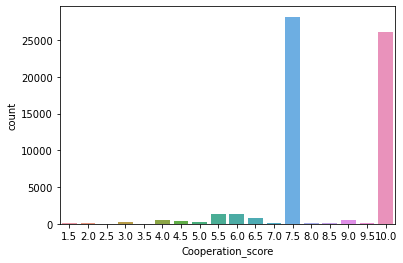

In [10]:
# Distribution of the Cooperation Scores:
sns.countplot(x=df["Cooperation_score"])

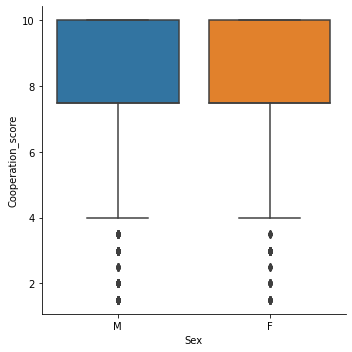

In [11]:
# Box plot for 'Sex':

sns.catplot(data=df, kind="box", x="Sex", y="Cooperation_score")

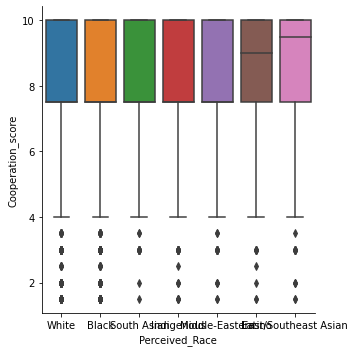

In [12]:
# Box plot for 'Perceived_Race':

sns.catplot(data=df, kind="box", x="Perceived_Race", y="Cooperation_score")

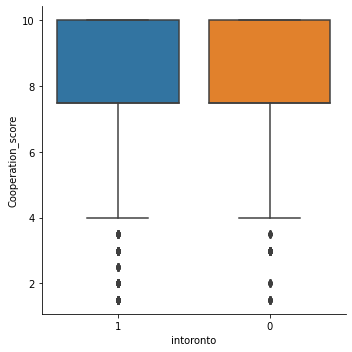

In [13]:
# Box plot for 'intoronto':

sns.catplot(data=df, kind="box", x="intoronto", y="Cooperation_score")

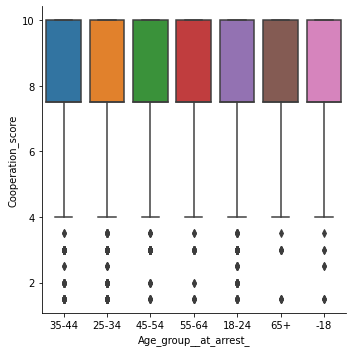

In [14]:
# Box plot for 'Age_group__at_arrest_':

sns.catplot(data=df, kind="box", x="Age_group__at_arrest_", y="Cooperation_score")

### T-tests:

In [15]:
def welch_dof(x, y): 
    '''
    Takes in final grades for binary features
    Returns degrees of freedom 
    '''
    dof = (x.var()/x.size + y.var()/y.size)**2 / (
        (x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof

#### 1. Conduct T-test on 'Sex' category (M is male, F is female):

In [16]:
M_score = df[df["Sex"] == "M"]['Cooperation_score']
F_score = df[df["Sex"] == "F"]['Cooperation_score']
print('Ttest results for Cooperation score:',stats.ttest_ind
      (M_score, F_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for M_score, F_score:',M_score.mean(), F_score.mean())
print('Standard deviation for M_score, F_score:',M_score.std(), F_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(M_score), sms.DescrStatsW(F_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(M_score, F_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=3.0514465837347644, pvalue=0.002280796050205465)
Mean score for M_score, F_score: 8.423945984950006 8.374807395993837
Standard deviation for M_score, F_score: 1.5548014565348212 1.5643368290218185
Confidence interval for Cooperation_score: (0.017574390353293667, 0.08070278755904314)
DOF for Cooperation_score: 17659.601610453232


#### 2. Conduct T-test on 'intoronto' category  (1 is in toronto, 0 is not in toronto):

In [17]:
int_score = df[df["intoronto"] == "1"]['Cooperation_score']
not_score = df[df["intoronto"] == "0"]['Cooperation_score']
print('Ttest results for Cooperation score:',stats.ttest_ind
      (int_score, not_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for int_score, not_score:',int_score.mean(), not_score.mean())
print('Standard deviation for int_score, not_score:',int_score.std(), not_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(int_score), sms.DescrStatsW(not_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(int_score, not_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-3.7616145069358002, pvalue=0.00016898027266410852)
Mean score for int_score, not_score: 8.392763198140331 8.440148401411268
Standard deviation for int_score, not_score: 1.6443393283543064 1.445343322952539
Confidence interval for Cooperation_score: (-0.07207544281670118, -0.02269496372517145)
DOF for Cooperation_score: 60067.40549784279


#### 3. Conduct T-test on 'Perceived_Race' category:

In [18]:
White_score = df[df["Perceived_Race"] == "White"]['Cooperation_score']
notW_score = df[df["Perceived_Race"] != "White"]['Cooperation_score']
print('Ttest results for Cooperation score:',stats.ttest_ind
      (White_score, notW_score, equal_var=False)) #p-value is NOT significant

# calculate mean and standard deviation of groups 
print('Mean score for White_score, notW_score:',White_score.mean(), notW_score.mean())
print('Standard deviation for White_score, notW_score:',
      White_score.std(), notW_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(White_score), sms.DescrStatsW(notW_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(White_score, notW_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-1.1238286609701196, pvalue=0.26109031573124564)
Mean score for White_score, notW_score: 8.406687599249315 8.42099510452908
Standard deviation for White_score, notW_score: 1.556621228761491 1.5568814864968605
Confidence interval for Cooperation_score: (-0.03926039554383341, 0.01064538498430299)
DOF for Cooperation_score: 58703.24274146539


#### 4. Conduct T-test on 'Age_group__at_arrest_' category:

In [19]:
younger_score = df[(df["Age_group__at_arrest_"] == "25-34") | 
                   (df["Age_group__at_arrest_"] == "-18")]['Cooperation_score']
older_score = df[(df["Age_group__at_arrest_"] != "25-34") & 
                 (df["Age_group__at_arrest_"] != "-18")]['Cooperation_score']
print('Ttest results for Cooperation score:',stats.ttest_ind
      (younger_score, older_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for younger_score, older_score:',younger_score.mean(), 
      older_score.mean())
print('Standard deviation for younger_score, older_score:',younger_score.std(), 
      older_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(younger_score), sms.DescrStatsW(older_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(younger_score, older_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-3.499847584772494, pvalue=0.0004659652780292937)
Mean score for younger_score, older_score: 8.385215150967275 8.431376927725088
Standard deviation for younger_score, older_score: 1.5650295932095113 1.5517093530104011
Confidence interval for Cooperation_score: (-0.07201370396701576, -0.020309849548610842)
DOF for Cooperation_score: 45914.73043826855


### Tukey's HSD:

#### 1. Conduct Tukey test on 'Sex':

In [20]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df['Cooperation_score'],
                          groups=df['Sex'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     F      M   0.0491 0.0022 0.0177 0.0806   True
--------------------------------------------------


#### 2. Conduct Tukey test on 'intoronto':

In [21]:
tukey = pairwise_tukeyhsd(df['Cooperation_score'],
                          groups=df['intoronto'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.0474 0.001 -0.0724 -0.0224   True
---------------------------------------------------


#### 3. Conduct Tukey test on 'Perceived_Race':

In [22]:
tukey = pairwise_tukeyhsd(df['Cooperation_score'],
                          groups=df['Perceived_Race'],
                          alpha=0.05)
print(tukey)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
               Black East/Southeast Asian   0.3181  0.001   0.241  0.3953   True
               Black           Indigenous  -0.1877  0.001 -0.2975 -0.0779   True
               Black               Latino   0.2521  0.001  0.1378  0.3664   True
               Black       Middle-Eastern   0.1574  0.001  0.0698  0.2451   True
               Black          South Asian   0.1719  0.001  0.0882  0.2556   True
               Black                White   0.0663  0.001  0.0221  0.1105   True
East/Southeast Asian           Indigenous  -0.5059  0.001 -0.6308 -0.3809   True
East/Southeast Asian               Latino   -0.066  0.712  -0.195  0.0629  False
East/Southeast Asian       Middle-Eastern  -0.1607  0.001 -0.2667 -0.0547   True
East/Southeast Asian        

#### 4. Conduct Tukey test on 'Age_group__at_arrest_':

In [23]:
tukey = pairwise_tukeyhsd(df['Cooperation_score'],
                          df['Age_group__at_arrest_'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   -18  18-24  -0.1427  0.001 -0.2414  -0.044   True
   -18  25-34  -0.1888  0.001 -0.2812 -0.0964   True
   -18  35-44  -0.1513  0.001 -0.2454 -0.0573   True
   -18  45-54  -0.0749 0.2878 -0.1747  0.0248  False
   -18  55-64  -0.0771 0.3911 -0.1886  0.0344  False
   -18    65+   0.0252    0.9 -0.1323  0.1827  False
 18-24  25-34  -0.0461 0.2259 -0.1043   0.012  False
 18-24  35-44  -0.0086    0.9 -0.0694  0.0521  False
 18-24  45-54   0.0678 0.0601 -0.0015   0.137  False
 18-24  55-64   0.0656 0.2602 -0.0197  0.1508  False
 18-24    65+   0.1679 0.0076  0.0277  0.3081   True
 25-34  35-44   0.0375 0.2871 -0.0124  0.0874  False
 25-34  45-54   0.1139  0.001  0.0539  0.1739   True
 25-34  55-64   0.1117  0.001  0.0338  0.1896   True
 25-34    65+    0.214  0.001  0.0781  0.3498   True
 35-44  45-54   0.0764 0.0058  0.0139  0.1389 

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

### Hypothesis 1: Perceived_Race and Sex vs Cooperation score

<AxesSubplot:xlabel='Perceived_Race', ylabel='Cooperation_score'>

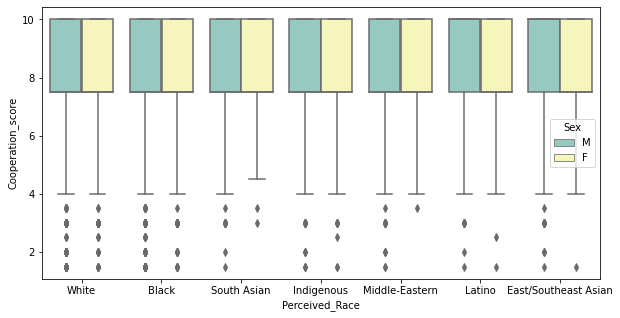

In [25]:
df_1 = df[["Perceived_Race", "Sex", "Cooperation_score"]]
plt.figure(figsize=(10,5))
sns.boxplot(x="Perceived_Race", y="Cooperation_score", hue="Sex", data=df_1, palette="Set3")

#### Interaction plot of Perceived_Race and Sex:

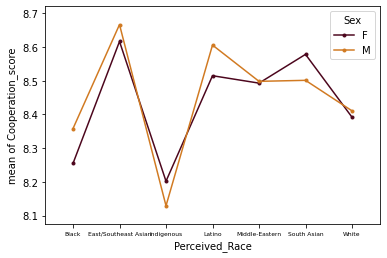

In [26]:
fig = interaction_plot(df['Perceived_Race'], df['Sex'], df['Cooperation_score'], colors=['#4c061d','#d17a22'])
plt.tick_params(axis="x", labelsize=6)
plt.show()

#### Two-way ANOVA test and regression models of Hypothesis 1:

In [27]:
model_1 = ols('Cooperation_score ~ C(Perceived_Race) + C(Sex) + C(Perceived_Race):C(Sex) ', data=df).fit()
anova_table_1 = sm.stats.anova_lm(model_1, typ=2)
anova_table_1

,sum_sq,df,F,PR(>F)
C(Perceived_Race),595.531029,6.0,41.127389,2.572650e-50
C(Sex),12.188980,1.0,5.050628,2.462063e-02
C(Perceived_Race):C(Sex),24.486327,6.0,1.691026,1.186513e-01
Residual,145219.075199,60173.0,NaN,NaN


In [28]:
# The regression model after fixed:

model_1_fix = ols('Cooperation_score ~ C(Perceived_Race) + C(Sex)', data=df).fit()
anova_table_1 = sm.stats.anova_lm(model_1_fix, typ=2)
anova_table_1

,sum_sq,df,F,PR(>F)
C(Perceived_Race),595.531029,6.0,41.124556,2.594104e-50
C(Sex),12.188980,1.0,5.050280,2.462557e-02
Residual,145243.561526,60179.0,NaN,NaN


In [29]:
model_1_fix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cooperation_score   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     36.60
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           1.75e-51
Time:                        14:25:39   Log-Likelihood:            -1.1191e+05
No. Observations:               60187   AIC:                         2.238e+05
Df Residuals:                   60179   BIC:                         2.239e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     8.3105      0.018    467.822      0.000       8.276       8.345
C(Perceived_Race)[T.East/Southeast Asian]     0.3180      0.026     12.153      0.000       0.267       0.369
C(Perceived_Race)[T.Indigenous]              -0.1822      0.037     -4.881      0.000      -0.255      -0.109
C(Perceived_Race)[T.Latino]                   0.2513      0.039      6.480      0.000       0.175       0.327
C(Perceived_Race)[T.Middle-Eastern]           0.1553      0.030      5.221      0.000       0.097       0.214
C(Perceived_Race)[T.South Asian]              0.1708      0.028      6.015      0.000       0.115       0.226
C(Perceived_Race)[T.White]                    0.0681      0.015      4.534      0.000       0.039       0.098
C(Sex)[T.M]                                   0.0362      0.016      2.247      0.025       0.005       0.068
==============================================================================
Omnibus:                     3589.225   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4291.338
Skew:                          -0.622   Prob(JB):                         0.00
Kurtosis:                       3.405   Cond. No.                         9.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Hypothesis 2: Located in Toronto or not and Age group at arrest vs Cooperation score

<AxesSubplot:xlabel='Age_group__at_arrest_', ylabel='Cooperation_score'>

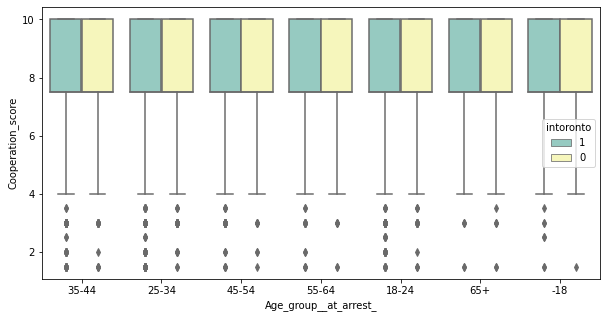

In [30]:
df_2 = df[["intoronto", "Age_group__at_arrest_", "Cooperation_score"]]
plt.figure(figsize=(10,5))
sns.boxplot(x="Age_group__at_arrest_", y="Cooperation_score", hue="intoronto", data=df_2, palette="Set3")

#### Interaction plot of Age_group__at_arrest_ and intoronto:

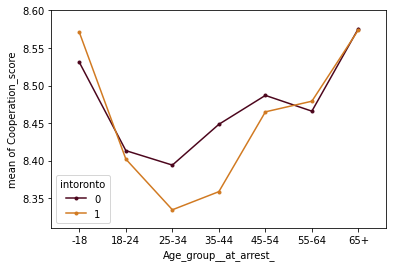

In [31]:
fig = interaction_plot(df['Age_group__at_arrest_'], df['intoronto'], df['Cooperation_score'], colors=['#4c061d','#d17a22'])
plt.show()

#### Two-way ANOVA test and regression models of Hypothesis 2:

In [32]:
model_2 = ols('Cooperation_score ~ C(intoronto) + C(Age_group__at_arrest_) + C(intoronto):C(Age_group__at_arrest_) ', data=df).fit()
anova_table_2 = sm.stats.anova_lm(model_2, typ=2)
anova_table_2

,sum_sq,df,F,PR(>F)
C(intoronto),28.067518,1.0,11.597641,6.607866e-04
C(Age_group__at_arrest_),181.964605,6.0,12.531450,3.584600e-14
C(intoronto):C(Age_group__at_arrest_),21.299441,6.0,1.466839,1.851015e-01
Residual,145625.027922,60173.0,NaN,NaN


In [33]:
# The regression model after fixed:

model_2_fix = ols('Cooperation_score ~ C(intoronto) + C(Age_group__at_arrest_)', data=df).fit()
anova_table_2 = sm.stats.anova_lm(model_2_fix, typ=2)
anova_table_2

,sum_sq,df,F,PR(>F)
C(intoronto),28.067518,1.0,11.597101,6.609783e-04
C(Age_group__at_arrest_),181.964605,6.0,12.530866,3.590537e-14
Residual,145646.327362,60179.0,NaN,NaN


In [34]:
model_2_fix.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cooperation_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     12.72
Date:                Sun, 26 Feb 2023   Prob (F-statistic):           2.01e-16
Time:                        14:25:41   Log-Likelihood:            -1.1200e+05
No. Observations:               60187   AIC:                         2.240e+05
Df Residuals:                   60179   BIC:                         2.241e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             8.5706      0.030    286.679      0.000       8.512       8.629
C(intoronto)[T.1]                    -0.0434      0.013     -3.405      0.001      -0.068      -0.018
C(Age_group__at_arrest_)[T.18-24]    -0.1400      0.033     -4.181      0.000      -0.206      -0.074
C(Age_group__at_arrest_)[T.25-34]    -0.1855      0.031     -5.916      0.000      -0.247      -0.124
C(Age_group__at_arrest_)[T.35-44]    -0.1479      0.032     -4.636      0.000      -0.211      -0.085
C(Age_group__at_arrest_)[T.45-54]    -0.0720      0.034     -2.128      0.033      -0.138      -0.006
C(Age_group__at_arrest_)[T.55-64]    -0.0754      0.038     -1.995      0.046      -0.150      -0.001
C(Age_group__at_arrest_)[T.65+]       0.0245      0.053      0.458      0.647      -0.080       0.129
==============================================================================
Omnibus:                     3568.398   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4258.881
Skew:                          -0.621   Prob(JB):                         0.00
Kurtosis:                       3.394   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""